In [2]:
import pandas as pd
import numpy as np
import os
import re
import string
import datetime
import pytz
import sys 
sys.path.append('..')
import funcs.ac_funcs as ac

# OOF

In [5]:
class oof_manager:
    '''Class to manage getting data from oof files'''

    def __init__(self,oof_data_folder,timezone):
        '''
        Args: 
        oof_data_folder (str) : path to the folder where oof data is stored
        timezone (str) : timezone for the measurments
        '''
        self.oof_data_folder = oof_data_folder
        self.timezone = timezone

    def load_oof_df_inrange(self,dt1,dt2,filter_flag_0=False,print_out=False,cols_to_load=None):
        '''Loads a dataframe from an oof file for datetimes between the input values
        
        Args:
        dt1_str (str) : string for the start time of the desired range of form "YYYY-mm-dd HH:MM:SS" 
        dt2_str (str) : string for the end time of the desired range of form "YYYY-mm-dd HH:MM:SS" 
        oof_filename (str) : name of the oof file to load
        filter_flag_0 (bool) : True will filter the dataframe to rows where the flag column is 0 (good data), false returns all the data
        print_out (bool) : Will print a message telling the user that they are loading a certain oof file. Default False. 
        cols_to_load (list) : List of strings that are the names of the oof data columns to load. Default is None, which loads all of the columns. 

        Returns:
        df (pd.DataFrame) : pandas dataframe loaded from the oof files, formatted date, and column names       
        '''
        if type(dt1) == str:
            dt1 = self.tzdt_from_str(dt1)
            dt2 = self.tzdt_from_str(dt2)
        oof_files_inrange = self.get_oof_in_range(dt1,dt2)
        full_df = pd.DataFrame()
        for oof_filename in oof_files_inrange:
            if print_out:
                print(f'Loading {oof_filename}')
            df = self.df_from_oof(oof_filename,fullformat = True, filter_flag_0 = filter_flag_0, cols_to_load=cols_to_load) #load the oof file to a dataframe
            #df = self.df_dt_formatter(df) #format the dataframe to the correct datetime and column name formats
            df = df.loc[(df.index>=dt1)&(df.index<=dt2)] #filter the dataframe between the input datetimes
            #if filter_flag_0: #if we want to filter by flag
            #    df = df.loc[df['flag'] == 0] #then do it!
            full_df = pd.concat([full_df,df])
        return full_df

    def df_from_oof(self,filename,fullformat = False,filter_flag_0 = False,cols_to_load=None):
        '''Load a dataframe from an oof file
        
        Args:
        filename (str) : name of the oof file (not the full path)
        fullformat (bool) : if you want to do the full format
        filter_flag_0 (bool) : if you want to only get the 0 flags (good data), set to True
        cols_to_load (list) : list of strings of the oof columns you want to load. Default None which loads all of the columns
        
        Returns:
        df (pd.DataFrame) : a pandas dataframe loaded from the em27 oof file with applicable columns added/renamed
        '''

        oof_full_filepath = os.path.join(self.oof_data_folder,filename) #get the full filepath using the class' folder path
        header = self.read_oof_header_line(oof_full_filepath)
        if cols_to_load == None: #if use_cols is none, we load all of the columns into the dataframe
            df = pd.read_csv(oof_full_filepath,
                            header = header,
                            delim_whitespace=True,
                            skip_blank_lines=False) #read it as a csv, parse the header
        else:
            must_have_cols = ['flag','year','day','hour','lat(deg)','long(deg)','zobs(km)'] #we basically always need these columns
            usecols = cols_to_load.copy() #copy the cols to load so it doesn't alter the input list (we often use "specs" or simlar)
            for mhc in must_have_cols: #loop through the must haves
                if mhc not in cols_to_load: #if they aren't in the columns to load
                    usecols.append(mhc) #add them 

            df = pd.read_csv(oof_full_filepath, #now load the dataframe with the specific columns defined
                header = header,
                delim_whitespace=True,
                skip_blank_lines=False,
                usecols = usecols) #read it as a csv, parse the header
                
        df['inst_zasl'] = df['zobs(km)']*1000 #add the instrument z elevation in meters above sea level (instead of km)
        df['inst_lat'] = df['lat(deg)'] #rename the inst lat column
        df['inst_lon'] = df['long(deg)'] #rename the inst lon column 
        if fullformat:
            df = self.df_dt_formatter(df)
        if filter_flag_0:
            df = df.loc[df['flag']==0]
        return df

    def tzdt_from_str(self,dt_str):
        '''Apply the inherent timezone of the class to an input datetime string
        
        Args:
        dt_str (str) : datetime string of form "YYYY-mm-dd HH:MM:SS" 
        
        Returns:
        dt (datetime.datetime) : timezone aware datetime object, with timezone determined by the class
        '''

        dt = datetime.datetime.strptime(dt_str,'%Y-%m-%d %H:%M:%S') #create the datetime
        dt = pytz.timezone(self.timezone).localize(dt) #apply the timezone
        return dt

    def read_oof_header_line(self,full_file_path):
        '''Reads and parses the header line of an oof file
        
        Args: 
        full_file_path (str) : full path to an oof file we want to read
        
        Returns:
        header (list) : list of column names to use in the header 
        '''

        with open(full_file_path) as f: #open the file
            line1 = f.readline() #read the first line
        header = int(line1.split()[0])-1 #plit the file and get the header
        return header

    def parse_oof_dt(self,year,doy,hr_dec):
        '''Get a real datetime from an oof style datetime definition
        
        Args:
        year (int) : year
        doy (int) : day of the year 
        hr_dec (float) : decimal hour of the day
        
        Returns:
        dt (pandas.datetime) : pandas datetime object gleaned from the inputs
        '''

        dt = pd.to_datetime(f'{int(year)} {int(doy)}',format='%Y %j') + datetime.timedelta(seconds = hr_dec*3600)
        return dt

    def df_dt_formatter(self,df):
        '''Format a loaded oof dataframe to have the correct datetime as an index

        Assumes that the oof timestamps are in UTC
        
        Args: 
        df (pd.DataFrame) : dataframe loaded using df_from_oof() 

        Returns:
        df (pd.DataFrame) : reformatted dataframe with datetime as the index, and converted to a timezone aware object. 
        '''

        df['dt'] = np.vectorize(self.parse_oof_dt)(df['year'],df['day'],df['hour']) #set the datetime column by parsing the year, day and hour columns
        df = df.set_index('dt',drop=True).sort_index() #set dt as the index
        df.index = df.index.tz_localize('UTC').tz_convert(self.timezone) #localize and convert the timezone
        return df

    def get_sorted_oof(self):
        '''Get a list of oof files in the oof data folder, sorted so they are in chron order
        
        Returns:
        files (list) : list of files ending in oof in the data folder
        '''

        files = [] #initialize the list
        for file in sorted(os.listdir(self.oof_data_folder)): #loop through the sorted filenames in the oof data folder
            if file.endswith('oof'): #if the file ends in oof
                files.append(file) #add it to the list
        return files

    def get_oof_in_range(self,dt1,dt2):
        '''Finds the oof files in the data folder that fall between two input datetimes
        
        Args:
        dt1 (str or datetime.datetime) : start datetime of the interval we want to find files within
        dt2 (str or datetime.datetime) : end datetime of the interfal we want to find files within
        
        Returns:
        files in range (list) : list of oof filenames that fall within the datetime range input
        '''
        dt1 = dt1 - datetime.timedelta(days=1) #sometimes with UTC there are values in the previous day's oof file, so start one behind to check
        daystrings_in_range = [] #initialize the day strings in the range
        delta_days = dt2.date()-dt1.date() #get the number of days delta between the end and the start
        for i in range(delta_days.days +1): #loop through that number of days 
            day = dt1.date() + datetime.timedelta(days=i) #get the day by incrementing by i (how many days past the start)
            daystrings_in_range.append(day.strftime('%Y%m%d')) #append a string of the date (YYYYmmdd) to match with filenames

        files_in_range = [] #initilize the filenames that will be in the range
        for file in self.get_sorted_oof(): #loop through the sorted oof files in the data folder
            for daystring_in_range in daystrings_in_range: # loop through the daystrings that are in the range
                if daystring_in_range in file: #if the daystring is in the filename, 
                    files_in_range.append(file) #append it. Otherwise keep going
        
        return files_in_range

    def date_from_oof(self,oof_filename):
        '''Strips the date from an oof filename
        
        Args: 
        oof_filename (str)

        Returns:
        date (datetime.datetime.date) : date gained from the oof filename
        '''

        try:
            datestring = oof_filename.split('.')[0][2:] #split the oof_filename on . and remove the two letter identifier 
            date = datetime.datetime.strptime(datestring,"%Y%m%d").date() #convert to a date
            return date
        except:
            raise Exception(f'Error in getting datestring from {oof_filename}')

    def get_inrange_dates(self,dt1,dt2):
        '''Gets a range of dates between an input datetime range
        
        Args:
        dt1 (datetime.datetime) : start datetime
        dt2 (datetime.datetime) : end datetime
        
        Returns:
        dates_in_range (list) : list of dates within the datetime range
        '''

        files_in_range = self.get_oof_in_range(dt1,dt2) #find the files in the range
        dates_in_range = [] #initialize the dates list
        for oof_filename in files_in_range: #loop through the files in the range
            inrange_date = self.date_from_oof(oof_filename) #grab the date
            dates_in_range.append(inrange_date) #and append it
        return dates_in_range

    def check_get_loc(self,oof_df):
        '''Checks and gets the location of the instrument from the oof file
        TODO: This will break if the location moves during data collection or between days. This could become an issue if data was collected
        during one day and went past midnight UTC, then moved to a differnt location the next day. The oof_df in this case for the secnod day
        would include some data from the first data colleciton session in the early UTC hours, before moveing. 

        Args: 
        oof_df (pd.DataFrame) : dataframe of oof values
        
        Returns: 
        inst_lat (float) : instrument latitude
        inst_lon (float) : instrument longitude
        inst_zasl (float) : instrument elevation above sea level in meters        
        '''

        cols_to_check = ['inst_lat','inst_lon','inst_zasl']
        for col in cols_to_check:
            if not pd.col_is_equal(oof_df[col]):
                raise Exception('{col} is not the same for the entire oof_df. This is an edge case.')
        #If we make it through the above, we can pull the values from the dataframe at the 0th index because they are all the same
        inst_lat = oof_df.iloc[0]['inst_lat']
        inst_lon = oof_df.iloc[0]['inst_lon']
        inst_zasl = oof_df.iloc[0]['inst_zasl']
        return inst_lat,inst_lon,inst_zasl   

In [18]:
#Load the side by side data for ua and ha so that we can correct to one another
data_folder = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/EM27_oof/SLC_EM27_ha_2022_2023_oof_v2_nasrin_correct'
filter_flag_0 = True #set to True if we want to filter bad spectra
timezone = 'UTC'  #timezone within which to load the dataframes
specs = ['xch4(ppm)','xco2(ppm)','xco(ppb)'] #these are the species we want to correct

#the datetime string ranges below are the ranges when the ua EM27 and ha EM27 were side by side on the roof of wbb
dt1_str = '2023-07-08 11:00:00'
dt2_str = '2023-07-09 21:59:59'

dt1 = datetime.datetime.strptime(dt1_str,'%Y-%m-%d %H:%M:%S') #create the datetime
dt1 = pytz.timezone('US/Mountain').localize(dt1) #apply the timezone

dt2 = datetime.datetime.strptime(dt2_str,'%Y-%m-%d %H:%M:%S') #create the datetime
dt2 = pytz.timezone('US/Mountain').localize(dt2) #apply the timezone

my_oof_manager = ac.oof_manager(data_folder,timezone) #create the oof manager for that instrument
#my_oof_manager.get_oof_in_range(dt1,dt2)
df = my_oof_manager.load_oof_df_inrange(dt1,dt2,filter_flag_0=filter_flag_0,cols_to_load=specs) #load the datetime in the range
df.index.tz_convert('US/Mountain')

DatetimeIndex(['2023-07-08 11:03:10.800000-06:00',
                      '2023-07-08 11:03:18-06:00',
               '2023-07-08 11:03:28.800000-06:00',
               '2023-07-08 11:03:32.400000-06:00',
               '2023-07-08 11:03:43.200000-06:00',
               '2023-07-08 11:03:46.800000-06:00',
               '2023-07-08 11:03:57.600000-06:00',
               '2023-07-08 11:04:01.200000-06:00',
                      '2023-07-08 11:04:12-06:00',
               '2023-07-08 11:04:19.200000-06:00',
               ...
               '2023-07-09 16:18:28.800000-06:00',
                      '2023-07-09 16:18:36-06:00',
               '2023-07-09 16:18:43.200000-06:00',
               '2023-07-09 16:18:50.400000-06:00',
               '2023-07-09 16:19:01.200000-06:00',
               '2023-07-09 16:19:08.400000-06:00',
               '2023-07-09 16:19:15.600000-06:00',
               '2023-07-09 16:19:22.800000-06:00',
               '2023-07-09 16:19:33.600000-06:00',
            

# Met data from GGG format

In [3]:
class met_loader_ggg:
    '''Class to handle loading meteorological data that has been formatted for use in GGG/EGI.
    Generally, data should be split into daily files of the form YYYYMMDD_em27id.siteid.txt, where em27id is the two character
    id like "UA" or "HA", and siteid is the mesowest site id like "WBB". 

    These files should contain the following columns:
    'UTCDate' : Date in UTC of form yy/mm/dd
    'UTCTime' : Time in UTC of form HH:MM:SS
    'Pout' : outside pressure, in hPa
    'Tout' : outside temperature, in deg C
    'RH' : relative humidity, in %
    'WSPD' : wind speed, in m/s
    'WDIR' : wind direction, in degrees clockwise from north
    'wind_na' : boolean indicating whether the WSPD was na in the raw data (changed to 0.0 for use in GGG, should be changed back)

    '''

    def __init__(self,daily_met_path):
        '''
        Args:
        daily_met_path (str) : path to where the daily txt met files are stored
        '''

        self.daily_met_path = daily_met_path

    def load_data_inrange(self,dt1,dt2):
        '''Loads all of the met data within a certin datetime range
        
        Args:
        dt1 (datetime.datetime) : a timezone aware datetime to start the data period
        dt2 (datetime.datetime) : a timezone aware datetime to end the data period
        
        Returns:
        full_dataframe (pandas.DataFrame) : a dataframe of all of the met data in the range, with a datetime index wind columns corrected
        '''

        files_in_range = self.get_files_inrange(dt1,dt2) #get the files that are in the range 
        full_dataframe = pd.DataFrame() #initialize the full dataframe
        for fname in files_in_range: #loop through the files in the range
            df = self.load_format_single_file(fname) #load and format the individual file
            full_dataframe = pd.concat([full_dataframe,df]) #concatenate it into the big dataframe
        full_dataframe = full_dataframe.loc[(full_dataframe.index>=dt1) & (full_dataframe.index<=dt2)] #snip the dataframe to the range
        return full_dataframe

    def load_format_single_file(self,fname):
        '''Loads and formats a single met file given the filename
        
        Args: 
        fname (str) : name of the file in the self.daily_met_path folder to load
        
        Returns:
        df (pandas.DataFrame) : loaded and formated dataframe including datetime index and wind correction
        '''

        df = self.load_single_file(fname) #load the file
        df = self.add_dt_index(df) #add the dt as an index
        df = self.wind_handler(df) #handle the wind values (deal with na and add u/v columns)
        return df

    def load_single_file(self,fname):
        '''Reads in a single file to a dataframe
        
        Args: 
        fname (str) : name of the file in the self.daily_met_path folder to load
        
        Returns:
        df (pandas.DataFrame) : raw loaded dataframe
        '''

        fullpath = os.path.join(self.daily_met_path,fname) #get the full path
        df = pd.read_csv(fullpath) #load the file
        return df
    
    def add_dt_index(self,df):
        '''Adds an index corresponding to the datetime based on the ggg file structure
        
        Args:
        df (pandas.DataFrame) : a dataframe loaded from a ggg style txt met file
        
        Returns:
        df (pandas.DataFrame) : the same dataframe, with a datetime index that is timezone aware (ggg style files should always be UTC)
        '''

        df.index = pd.to_datetime(df['UTCDate']+' '+df['UTCTime'],format='%y/%m/%d %H:%M:%S').dt.tz_localize('UTC') #parse the datetime
        return df
    
    def wind_handler(self,df):
        '''This handles the wind columns which are often manipulated to allow for running in EGI.
        
        Read more in mesowest_met_handler.py. Basically, we can't have any NaNs or blanks in the wind columns to run EGI, so we replace them 
        with 0.0. However, this does not mean they are actually 0, so we have added a "wind_na" column indicating if the wind speed values
        are actually 0 or if they were na. Wind direction values will always be na if windspeed is either 0 or na. 
        
        Args:
        df (pandas.DataFrame) : a dataframe loaded from a ggg style txt met file
        
        Returns:
        df (pandas.DataFrame) : the same dataframe with na values put in the right spots, and u and v wind vector columns added
        '''
        df.loc[df['WSPD'] == 0, 'WDIR'] = np.nan #can't have a wind direction if the wind speed is 0, so set it to nan
        if 'wind_na' in df.columns: #if there isn't a wind_na column, just return the dataframe
            df.loc[df['wind_na'] == True, 'WSPD'] = np.nan #if the windspeed was na (wind_na is true), set it back to na instead of 0 
        df[['u','v']] = df.apply(lambda row: ac.wdws_to_uv(row['WSPD'],row['WDIR']),axis = 1,result_type='expand') #add wind columns for u and v to do averaging if needed
        return df
        
    def get_files_inrange(self,dt1,dt2):
        '''This gets the files that contain data in the range between dt1 and dt2
        
        Args:
        dt1 (datetime.datetime) : a timezone aware datetime to start the data period
        dt2 (datetime.datetime) : a timezone aware datetime to end the data period
        
        Returns:
        files_in_range (list) : a list of filenames only, in the self.daily_met_path, that fall in the dt range
        '''
        daystrings_in_range = [] #initialize the day strings in the range
        delta_days = dt2.date()-dt1.date() #get the number of days delta between the end and the start
        for i in range(delta_days.days +1): #loop through that number of days 
            day = dt1.date() + datetime.timedelta(days=i) #get the day by incrementing by i (how many days past the start)
            daystrings_in_range.append(day.strftime('%Y%m%d')) #append a string of the date (YYYYmmdd) to match with filenames
        files_in_range = [] #initilize the filenames that will be in the range
        for file in self.get_sorted_fnames(): #loop through the sorted oof files in the data folder
            for daystring_in_range in daystrings_in_range: # loop through the daystrings that are in the range
                if daystring_in_range in file: #if the daystring is in the filename, 
                    files_in_range.append(file) #append it. Otherwise keep going
        return files_in_range

    def get_sorted_fnames(self):
        '''Sorts the filenames within the daily met path
        
        Returns:
        (list) : a sorted list of all of the elements within the daily_met_path
        '''
        
        return sorted(os.listdir(self.daily_met_path))
        
    
    

daily_met_path = '/uufs/chpc.utah.edu/common/home/u0890904/LAIR_1/Data/met/wbb/daily_txt_gggformat/'
dt1_str = '2023-08-09 00:00:00'
dt2_str = '2023-08-09 23:59:59'
timezone = 'UTC'

dt1 = datetime.datetime.strptime(dt1_str,'%Y-%m-%d %H:%M:%S') #create the datetime
dt1 = pytz.timezone(timezone).localize(dt1) #apply the timezone

dt2 = datetime.datetime.strptime(dt2_str,'%Y-%m-%d %H:%M:%S') #create the datetime
dt2 = pytz.timezone(timezone).localize(dt2) #apply the timezone

mlg = met_loader_ggg(daily_met_path)
full_df = mlg.load_data_inrange(dt1,dt2)

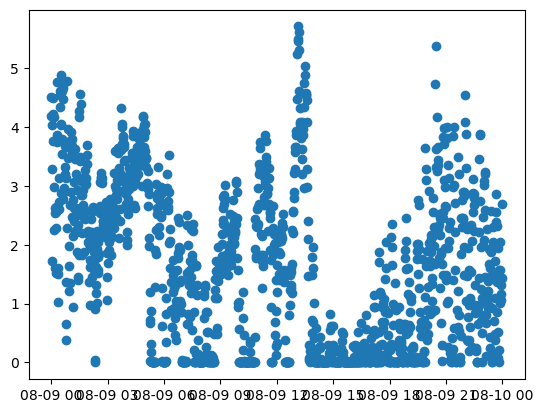

In [4]:
import matplotlib.pyplot as plt
plt.scatter(full_df.index,full_df['WSPD'])
#plt.scatter(full_df['WDIR'])

# Trisonica

In [11]:
class met_loader_trisonica:
    '''Class to handle loading meteorological data that has been collected by a Trisonica anemometer
    Generally, data are recorded as daily files of the form YYYYMMDD_anem.txt. 

    The form of these files is a bit weird. There are often blank lines between lines of data, and the data lines look something like this:
    ET= 1690299686.988468 DT= 2023-07-25 15:41:26.988468 S  02.61 D  073 U -02.48 V -00.77 W -00.30 T  20.56 H  68.93 DP  14.66 P  849.52 \
        AD  0.9979916 PI -000.1 RO -001.5 MD  011 TD  011
    
    '''

    def __init__(self,daily_met_path,resample_interval):
        '''
        Args:
        daily_met_path (str) : path to where the daily txt met files are stored
        '''

        self.daily_met_path = daily_met_path
        self.resample_interval = resample_interval
        self.headers_list = ['ET','Date','Time','S','D','U','V','W','T','H','DP','P','AD','PI','RO','MD','TD']


    def load_data_inrange(self,dt1,dt2):
        '''Loads all of the met data within a certin datetime range
        
        Args:
        dt1 (datetime.datetime) : a timezone aware datetime to start the data period
        dt2 (datetime.datetime) : a timezone aware datetime to end the data period
        
        Returns:
        full_dataframe (pandas.DataFrame) : a dataframe of all of the met data in the range
        '''

        files_in_range = self.get_files_inrange(dt1,dt2) #get the files that are in the range 
        full_dataframe = pd.DataFrame() #initialize the full dataframe
        for fname in files_in_range: #loop through the files in the range
            df = self.load_format_single_file(fname) #load and format the individual file
            full_dataframe = pd.concat([full_dataframe,df]) #concatenate it into the big dataframe
        full_dataframe = full_dataframe.loc[(full_dataframe.index>=dt1) & (full_dataframe.index<=dt2)] #snip the dataframe to the range
        return full_dataframe

    def load_format_single_file(self,fname):
        '''Loads and formats a single met file given the filename
        
        Args: 
        fname (str) : name of the file in the self.daily_met_path folder to load
        
        Returns:
        df (pandas.DataFrame) : loaded and formated dataframe including datetime index 
        '''

        fullpath = os.path.join(self.daily_met_path,fname) #get the full path
        with open(fullpath,'r',errors='ignore') as f: #we need to do some more sophisticated loading
            rows_list = [] #initialize a list to store the rows of data
            for i,line in enumerate(f): #loop through each line in the file
                newline = line.strip() #strip the newline character
                if len(newline) < 5: #if there are less than 5 characters, it's a bad line, so skip it
                    continue
                newline = newline.replace('=','') #replace equal signs with nothing
                for let in string.ascii_letters.replace('n','').replace('a',''): #replace any ascci characters with nothing
                    newline = newline.replace(let,'')
                newline = newline.replace(',',' ') #replace commas with a space
                if newline[0] == ' ': #if the line starts with a space, remove it
                    newline = newline[1:]
                newline = re.sub(r"\s+",",",newline) #substitute whitespace with a comma
                line_to_append = newline.split(',') # split the line by comma, should be all the good data
                if len(line_to_append) == len(self.headers_list): #check to make sure the number of data elements from the split lines matches the headers 
                    rows_list.append(line_to_append) #if so, append it to the rows list
            df = pd.DataFrame(rows_list) #create a dataframe from the rows
            df.columns = self.headers_list #set the columns to be the headers from the headers list
            for col in df.columns: #make the data numeric for all columns
                df[col] = pd.to_numeric(df[col],errors='coerce')
            df = df.dropna(axis = 1,how = 'all') #drop na where all
            df['DT'] = pd.to_datetime(df['ET'],unit='s') #set the datetime using the epoch time
            df = df.set_index('DT') #make the datetime the index
            df.index = df.index.tz_localize('UTC') #add timezone to index, should be UTC
            df = df.drop(['S','D'],axis = 1) #drop speed and direction since we have U and V and don't want to mess up averaging 
        if self.resample_interval is not None:
            df = df.resample(self.resample_interval).mean(numeric_only=True) #resample
        return df
    
    def get_files_inrange(self,dt1,dt2):
        '''This gets the files that contain data in the range between dt1 and dt2
        
        Args:
        dt1 (datetime.datetime) : a timezone aware datetime to start the data period
        dt2 (datetime.datetime) : a timezone aware datetime to end the data period
        
        Returns:
        files_in_range (list) : a list of filenames only, in the self.daily_met_path, that fall in the dt range
        '''
        daystrings_in_range = [] #initialize the day strings in the range
        delta_days = dt2.date()-dt1.date() #get the number of days delta between the end and the start
        for i in range(delta_days.days +1): #loop through that number of days 
            day = dt1.date() + datetime.timedelta(days=i) #get the day by incrementing by i (how many days past the start)
            daystrings_in_range.append(day.strftime('%Y%m%d')) #append a string of the date (YYYYmmdd) to match with filenames
        files_in_range = [] #initilize the filenames that will be in the range
        for file in self.get_sorted_fnames(): #loop through the sorted oof files in the data folder
            for daystring_in_range in daystrings_in_range: # loop through the daystrings that are in the range
                if daystring_in_range in file: #if the daystring is in the filename, 
                    files_in_range.append(file) #append it. Otherwise keep going
        return files_in_range

    def get_sorted_fnames(self):
        '''Sorts the filenames within the daily met path
        
        Returns:
        (list) : a sorted list of all of the elements within the daily_met_path
        '''
        
        return sorted(os.listdir(self.daily_met_path))
        

In [12]:
daily_met_path = '/uufs/chpc.utah.edu/common/home/lin-group15/agm/em27/ua/inst_data/met/trisonica_anem/'
dt1_str = '2023-07-28 15:00:00'
dt2_str = '2023-07-29 17:00:00'
timezone = 'UTC'

dt1 = datetime.datetime.strptime(dt1_str,'%Y-%m-%d %H:%M:%S') #create the datetime
dt1 = pytz.timezone(timezone).localize(dt1) #apply the timezone

dt2 = datetime.datetime.strptime(dt2_str,'%Y-%m-%d %H:%M:%S') #create the datetime
dt2 = pytz.timezone(timezone).localize(dt2) #apply the timezone

tri = met_loader_trisonica(daily_met_path,'T')
tri.load_data_inrange(dt1,dt2)

,ET,U,V,W,T,H,DP,P,AD,PI,RO,MD,TD
DT,,,,,,,,,,,,,
2023-07-28 15:00:00+00:00,1.690556e+09,-1.517845,0.227586,-0.005603,22.046207,46.157241,9.937328,846.15,0.990981,-0.831897,-3.232759,10.689655,10.698413
2023-07-28 15:01:00+00:00,1.690556e+09,-1.574087,0.321043,-0.002522,21.673217,46.936348,9.856783,846.15,0.992263,-0.877391,-3.272174,10.765217,10.730159
2023-07-28 15:02:00+00:00,1.690557e+09,-1.230776,0.289310,-0.037759,21.926379,46.071466,9.809310,846.15,0.991427,-0.859483,-3.255172,10.741379,10.806452
2023-07-28 15:03:00+00:00,1.690557e+09,-1.265739,0.255739,0.051130,22.394348,45.537043,10.055478,846.15,0.989768,-0.867826,-3.231304,10.460870,10.492063
2023-07-28 15:04:00+00:00,1.690557e+09,-1.129735,0.127345,-0.020796,22.339558,45.907699,10.124248,846.15,0.989929,-0.953097,-3.206195,10.238938,10.262295
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-07-29 16:56:00+00:00,1.690650e+09,-3.877350,2.347521,0.521111,25.112479,33.452735,7.909402,847.37,0.982904,-0.926496,-3.276068,9.957265,9.950820
2023-07-29 16:57:00+00:00,1.690650e+09,-4.421795,2.941538,0.553077,24.859573,33.820085,7.848120,847.37,0.983759,-0.956410,-3.283761,9.880342,9.920635
2023-07-29 16:58:00+00:00,1.690650e+09,-4.761121,3.322586,0.687672,24.945345,33.131207,7.622759,847.37,0.983549,-0.881897,-3.297414,9.905172,9.952381


In [ ]:
def read_all_trisonica_to_df(trisonica_data_path,trisonica_resample_interval):
    headers_list = ['ET','Date','Time','S','D','U','V','W','T','H','DP','P','AD','PI','RO','MD','TD']
    trisonica_df = pd.DataFrame()
    for file in os.listdir(trisonica_data_path):
        fullpath = os.path.join(trisonica_data_path,file)
        with open(fullpath,'r',errors='ignore') as f:
            rows_list = []
            for i,line in enumerate(f):
                newline = line.strip()
                if len(newline) < 5:
                    continue
                newline = newline.replace('=','')
                for let in string.ascii_letters.replace('n','').replace('a',''):
                    newline = newline.replace(let,'')
                newline = newline.replace(',',' ')
                if newline[0] == ' ':
                    newline = newline[1:]
                newline = re.sub(r"\s+",",",newline)
                line_to_append = newline.split(',')
                if len(line_to_append) == len(headers_list):
                    rows_list.append(line_to_append)
            df = pd.DataFrame(rows_list)
            df.columns = headers_list
            for col in df.columns:
                df[col] = pd.to_numeric(df[col],errors='coerce')
            df = df.dropna(axis = 1,how = 'all')
            df['DT'] = pd.to_datetime(df['ET'],unit='s')
            df = df.set_index('DT')
            df.index = df.index.tz_localize('UTC').tz_convert(timezone)
            df = df.drop(['S','D'],axis = 1)
            if trisonica_resample_interval is not None:
                df = df.resample(trisonica_resample_interval).mean(numeric_only=True)
        trisonica_df = pd.concat([trisonica_df,df])
    trisonica_df = trisonica_df.sort_index()
    trisonica_df['ws'],trisonica_df['wd'] = np.vectorize(ac.uv_to_wdws)(trisonica_df['U'],trisonica_df['V'])
    return trisonica_df